### Constants

In [1]:
WRITE_DIR = "../data/combined"
TRACK_LENGTH = 5

### Imports

In [2]:
import pickle
import uuid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

### Helper Functions

In [3]:
def chunk_group(group):
    if len(group) > TRACK_LENGTH:
        count = 0
        
        for idx, row in group.iterrows():
            if count % TRACK_LENGTH == 0:
                new_id = str(uuid.uuid4())
        
            group.at[idx, "UUID"] = new_id
            count += 1
            
    return group

### Combine Simulated Data (DON'T NEED TO RUN!)
Combine all the simulated csv files (1-21) into a single dataframe.

In [4]:
# import glob
# files = glob.glob("../data/raw/simulated/simulatedDroneData*.csv")
# combined_df = pd.DataFrame()
# 
# for file in files:
#     df = pd.read_csv(file)
#     df["UUID"] = "None"
#     
#     identifier = str(uuid.uuid4())
#     for idx, row in df.iterrows():
#         if idx % 20 == 0:
#             identifier = str(uuid.uuid4())
#         df.at[idx, "UUID"] = identifier
# 
#     # print(f"{len(df)}: {len(df["UUID"].unique())}")
#     combined_df = pd.concat([combined_df, df])
# 
# grouped_df = combined_df.groupby("UUID")
# print(f"number of plots: {len(combined_df)}")
# print(f"number of UUIDs: {len(grouped_df)}")
# 
# size = grouped_df.size()
# print(f"\tmax track size: {max(size)}")
# print(f"\tmin track size: {min(size)}")
# print(f"\tmean track size: {size.mean()}")

### Save Combined Dataframe (DON'T NEED TO RUN!)

In [5]:
# combined_df.to_csv("../data/raw/simulated/combinedSimulatedData.csv", index=False)

### Read ECCO, Simulated, and GPS Data

In [6]:
gps_path = "../data/raw/gps/processedGPSData.csv"
simu_path = "../data/raw/simulated/combinedSimulatedData.csv"
ecco_path = "../data/raw/crane/ecco.csv"
drone_data = "../data/raw/crane/Hostile_Radar_Data.csv"

gps_df = pd.read_csv(gps_path)
simu_df = pd.read_csv(simu_path)
ecco_df = pd.read_csv(ecco_path)
drone_df = pd.read_csv(drone_data)

print(f"GPS: {gps_df.columns}")
print(f"SIMU: {simu_df.columns}")
print(f"ECCO: {ecco_df.columns}")
print(f"DRONE: {drone_df.columns}")

GPS: Index(['UpdateTime', 'Position_lat_', 'Position_lon_', 'Position_altMSL_',
       'Speed', 'UUID', 'Range', 'AZ', 'EL', 'RadialVelocity'],
      dtype='object')
SIMU: Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID'],
      dtype='object')
ECCO: Index(['UUID', 'Name', 'Create Time', 'Update Time', 'User Edit Time', 'Type',
       'Associated UUID', 'Note', 'Source Name', 'Source Class', 'Source LID',
       'Combat ID', 'Object ID', 'Range To Contact', 'Bearing To Contact',
       'Creator', 'Editor', 'AZ', 'EL', 'Range', 'Position (lat)',
       'Position (lon)', 'Position (alt MSL)', 'Origin Position (lat)',
       'Origin Position (lon)', 'Origin Position (alt MSL)', '2525', 'Speed',
       'Radar Cross Section', 'Closest Time', 'Course', 'Source ID',
       'Radial Velocity', 'Closest Distance', 'Deleted', 'Deleted Time',
       'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 'AIS Ship Type',
     

/var/folders/sx/0gyr6z3573gdm1mnzzc8vw980000gn/T/ipykernel_1696/2779346472.py:8: DtypeWarning: Columns (0,1,2,3,4,5,6,8,9,11,12,26,34,35,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  ecco_df = pd.read_csv(ecco_path)


### Analyze Tracks in Each File

In [7]:
df_name_pairs = [(gps_df, "GPS"), (simu_df, "SIMULATED"), (ecco_df, "ECCO"), (drone_df, "DRONE")]
for df, name in df_name_pairs:
    print(f"* ============================== {name} ============================== *")
    
    grouped_df = df.groupby("UUID")
    print(f"number of plots: {len(df)}")
    print(f"number of UUIDs: {len(grouped_df)}")
    
    size = grouped_df.size()
    print(f"\tmax track size: {max(size)}")
    print(f"\tmin track size: {min(size)}")
    print(f"\tmean track size: {size.mean()}")


* ============================== GPS ============================== *
number of plots: 51900
number of UUIDs: 1260
	max track size: 76
	min track size: 39
	mean track size: 41.19047619047619
* ============================== SIMULATED ============================== *
number of plots: 1708
number of UUIDs: 94
	max track size: 20
	min track size: 1
	mean track size: 18.170212765957448
* ============================== ECCO ============================== *
number of plots: 17587
number of UUIDs: 84
	max track size: 1017
	min track size: 2
	mean track size: 113.72619047619048
* ============================== DRONE ============================== *
number of plots: 11403
number of UUIDs: 9
	max track size: 2753
	min track size: 530
	mean track size: 1267.0


### Break ECCO Tracks Down

In [8]:
ecco_df = ecco_df.groupby("UUID").apply(chunk_group).reset_index(drop=True)

In [9]:
print(f"* ============================== ECCO ============================== *")

grouped_ecco = ecco_df.groupby("UUID")
print(f"number of plots: {len(ecco_df)}")
print(f"number of UUIDs: {len(grouped_ecco)}")

size = grouped_ecco.size()
print(f"\tmax track size: {max(size)}")
print(f"\tmin track size: {min(size)}")
print(f"\tmean track size: {size.mean()}")

* ============================== ECCO ============================== *
number of plots: 9553
number of UUIDs: 1944
	max track size: 5
	min track size: 1
	mean track size: 4.914094650205762


### Break Drone Tracks Down

In [10]:
drone_df = drone_df.groupby("UUID").apply(chunk_group).reset_index(drop=True)

In [11]:
print(f"* ============================== DRONE ============================== *")

grouped_drone = drone_df.groupby("UUID")
print(f"number of plots: {len(drone_df)}")
print(f"number of UUIDs: {len(grouped_drone)}")

size = grouped_drone.size()
print(f"\tmax track size: {max(size)}")
print(f"\tmin track size: {min(size)}")
print(f"\tmean track size: {size.mean()}")

* ============================== DRONE ============================== *
number of plots: 11403
number of UUIDs: 2284
	max track size: 5
	min track size: 1
	mean track size: 4.992556917688266


### Match the Column Names

In [12]:
ecco_df_new = ecco_df.drop(columns=['Name', 'Create Time', 'User Edit Time', 'Type', 'Associated UUID', 
                      'Note', 'Source Name', 'Source Class', 'Source LID', 'Combat ID',
                      'Object ID', 'Range To Contact', 'Bearing To Contact', 'Creator',
                      'Editor', 'Origin Position (lat)', 'Origin Position (lon)', 
                      'Origin Position (alt MSL)', '2525', 'Radar Cross Section', 
                      'Closest Time', 'Course', 'Source ID', 'Closest Distance', 
                      'Deleted', 'Deleted Time', 'AIS MMSI', 'AIS IMO', 'AIS Call Sign', 
                      'AIS Ship Type', 'AIS Destination', 'AIS ETA', 'Fused', 'Fused Tracks'])

ecco_df_new = ecco_df_new.rename(
    columns={
        'Update Time': 'UpdateTime',
        'Position (lat)': 'Position_lat_',
        'Position (lon)': 'Position_lon_',
        'Position (alt MSL)': 'Position_altMSL_',
        'Radial Velocity': 'RadialVelocity'
    }, 
    errors='raise'
)

ecco_df_new = ecco_df_new.reindex(columns=simu_df.columns)
ecco_df_new["Label"] = 0

In [13]:
drone_df_new = drone_df.rename(
    columns={
        'Update Time': 'UpdateTime',
        'Position (lat)': 'Position_lat_',
        'Position (lon)': 'Position_lon_',
        'Position (alt MSL)': 'Position_altMSL_',
        'Radial Velocity': 'RadialVelocity'
    }, 
    errors='raise'
)

drone_df_new = drone_df_new.reindex(columns=simu_df.columns)
drone_df_new["Label"] = 1

In [14]:
gps_df = gps_df.reindex(columns=simu_df.columns)
gps_df["Label"] = 1

simu_df["Label"] = 1

In [15]:
print(ecco_df_new.columns)
print(drone_df_new.columns)
print(simu_df.columns)
print(gps_df.columns)

print(f"\nGPS columns == simulated columns ? {all(gps_df.columns == simu_df.columns)}")
print(f"simulated columns == ECCO columns ? {all(simu_df.columns == ecco_df_new.columns)}")
print(f"ECCO columns == DRONE columns ? {all(ecco_df_new.columns == drone_df_new.columns)}")

Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')

GPS columns == simulated columns ? True
simulated columns == ECCO columns ? True
ECCO columns == DRONE columns ? True


### Combine DataFrames into One

In [16]:
X = pd.concat([gps_df, ecco_df_new, simu_df])
print(f"Shape of combined df: {X.shape}")
print(X.columns)

Shape of combined df: (63161, 11)
Index(['UpdateTime', 'AZ', 'EL', 'Range', 'Position_lat_', 'Position_lon_',
       'Position_altMSL_', 'Speed', 'RadialVelocity', 'UUID', 'Label'],
      dtype='object')


### Save Data to CSVs

In [17]:
# X.to_csv(f"{WRITE_DIR}/ecco_simu_gps_10.csv")
# drone_df_new.to_csv(f"{WRITE_DIR}/drone_05.csv")

### Functions for Calculating Feature Vectors

In [18]:
def calculate_avg_speed(input_df):
    return input_df["Speed"].mean()

def calculate_std_speed(input_df):
    return input_df["Speed"].std()

def calculate_heading(input_df):
    delta_x = input_df["Position_lat_"] - input_df["Position_lat_"].shift(-1)
    delta_y = input_df["Position_lon_"] - input_df["Position_lon_"].shift(-1)   
    return np.arctan2(delta_y, delta_x)

def calculate_std_heading(input_df):
    heading = calculate_heading(input_df)
    return np.std(heading)

def calculate_osc_factor(input_df):
    heading = calculate_heading(input_df)
    theta = heading.shift(1) - heading

    om = theta.copy(deep=True)
    om[theta > 0.5] = 1
    om[theta < -0.5] = -1
    om[abs(theta) <= 0.5] = 0

    w = om.copy(deep=True)
    osc_number = 1
    for j in range(1, om.shape[0]-1):
        w[j] = osc_number    

### Form Feature Vector DataFrame

In [19]:
X_grouped = X.groupby("UUID")

avg_speed = calculate_avg_speed(X_grouped)
std_speed = calculate_std_speed(X_grouped)
std_heading = X_grouped.apply(calculate_std_heading)
mav_factor = avg_speed / std_heading

X_new = pd.DataFrame({
    'avg_speed': avg_speed,
    'std_speed': std_speed,
    'std_heading': std_heading,
    'mav_factor': mav_factor
})

X_new.replace([np.nan], 0, inplace=True)
X_new.replace([np.inf], 99999, inplace=True)
X_new.replace([-np.inf], -99999, inplace=True)

y_new = X_grouped["Label"].first()

In [20]:
print(X_new.head())
print(" ")

val_counts = y_new.value_counts()
print(val_counts)

check1 = val_counts[0] == len(ecco_df_new.groupby("UUID"))
print(f"\nBird labels in y_new == number of bird tracks ? {check1}")

check2 = val_counts[1] == (len(gps_df.groupby("UUID")) + len(simu_df.groupby("UUID")))
print(f"Drone labels in y_new == number of drone tracks ? {check2}")

check3 = len(X_new) == len(y_new)
print(f"Length of X_new == length of y_new ? {check3}")

                                      avg_speed  std_speed  std_heading  \
UUID                                                                      
0030dc8b-c8a7-4b1c-9f1d-e046b4451e42   9.948186   0.174578     0.205183   
0036654e-8ec0-40fc-98e9-da239b3e2012   8.655319   0.072421     0.025670   
007cce82-4ced-4c4e-b5b4-d8a25a50ebe7   6.691532   0.043745     0.031296   
00aca614-e800-4e10-afef-4010666d3cd3   7.622502   0.639989     0.043732   
00d07c7f-8dac-47ae-a9cc-f3ea57f5a2e0   9.711575   0.863517     2.471271   

                                      mav_factor  
UUID                                              
0030dc8b-c8a7-4b1c-9f1d-e046b4451e42   48.484499  
0036654e-8ec0-40fc-98e9-da239b3e2012  337.179007  
007cce82-4ced-4c4e-b5b4-d8a25a50ebe7  213.815538  
00aca614-e800-4e10-afef-4010666d3cd3  174.301393  
00d07c7f-8dac-47ae-a9cc-f3ea57f5a2e0    3.929789  
 
Label
1    1354
0     993
Name: count, dtype: int64

Bird labels in y_new == number of bird tracks ? True
Drone lab

### Train Model

In [21]:
# split the data into distinct training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2)

# define the classifier
rf = RandomForestClassifier()

# fit model on training data
rf.fit(X_train, y_train)

# use the trained model to generate predictions
rf_pred = rf.predict(X_test)

# get the confidence levels of each model
rf_confidence_pair = rf.predict_proba(X_test)

In [22]:
accuracy = metrics.accuracy_score(y_test, rf_pred)
print(f'accuracy = {100 * accuracy}')

accuracy = metrics.f1_score(y_test, rf_pred)
print(f'f1 score = {100 * accuracy}')

rf_confidence = [max(pair) for pair in rf_confidence_pair]
avg_rf_confidence = np.mean(rf_confidence)
med_rf_confidence = np.median(rf_confidence)

print(f'\naverage confidence level: {avg_rf_confidence}')
print(f'median confidence level: {med_rf_confidence}')

accuracy = 95.74468085106383
f1 score = 96.09375

average confidence level: 0.967063829787234
median confidence level: 1.0


### Visualize Decision Trees

number of trees in rf: 100


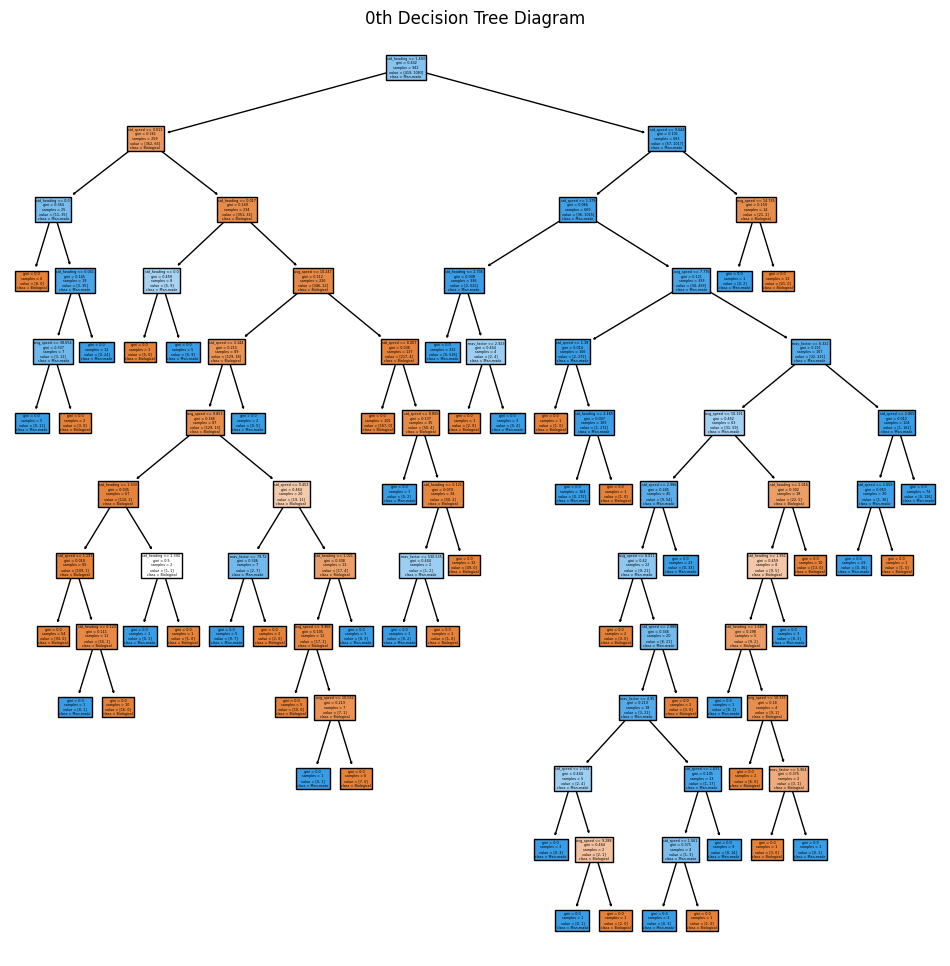

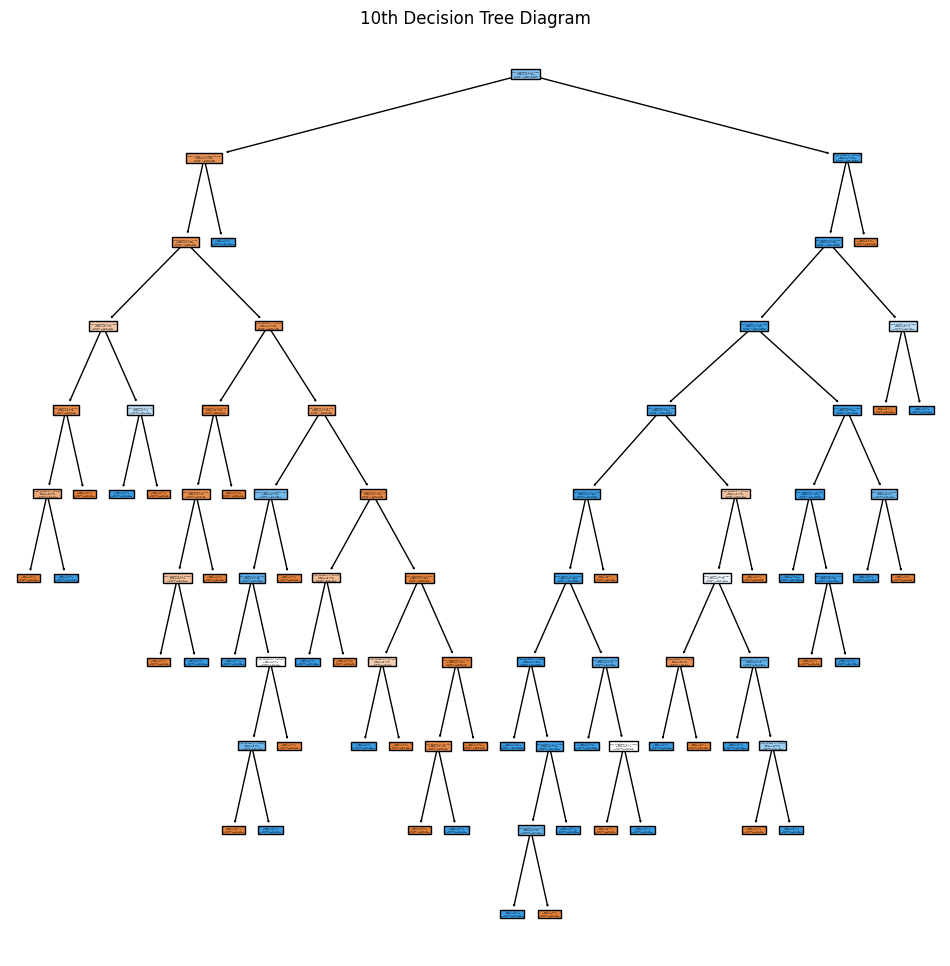

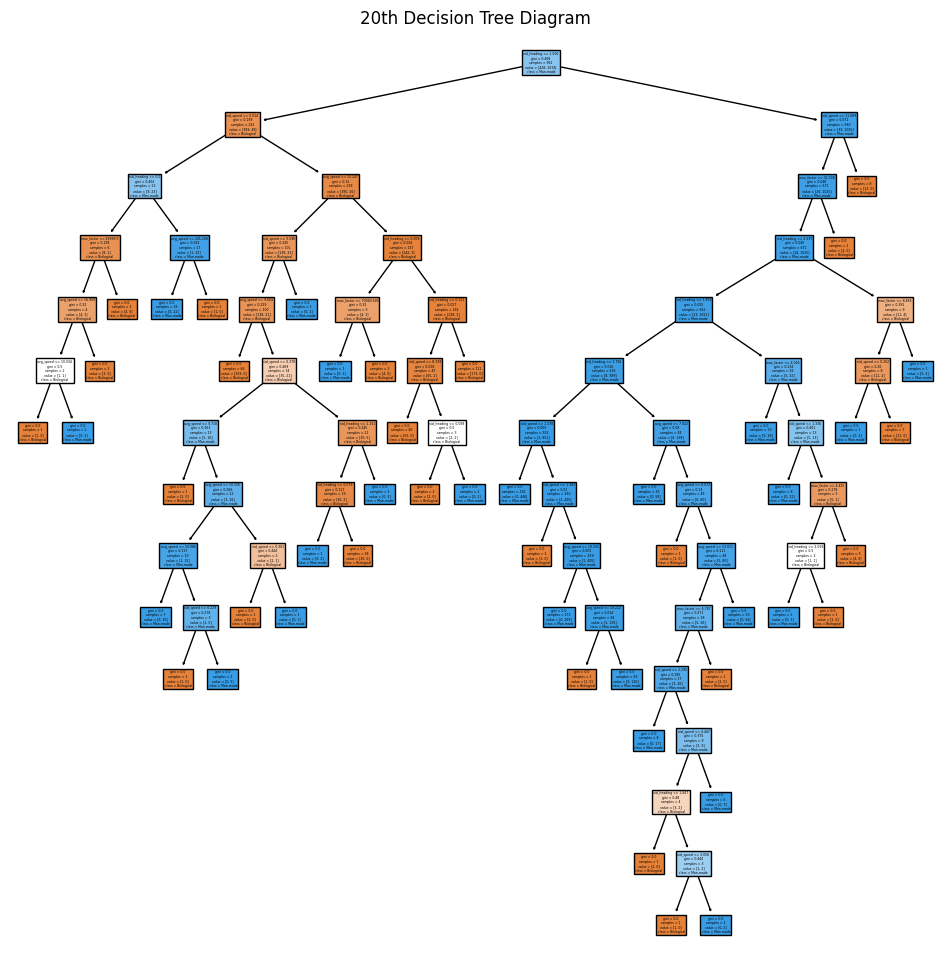

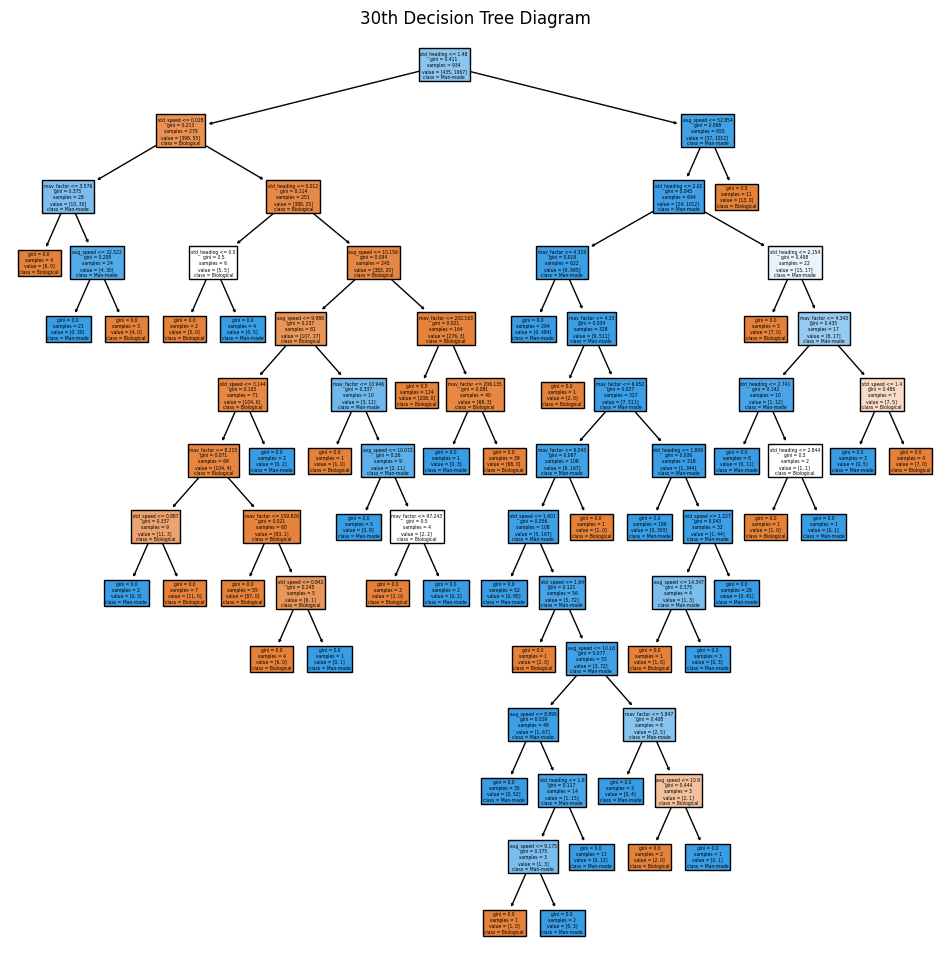

In [30]:
print(f'number of trees in rf: {len(rf.estimators_)}')

for i in [0, 10, 20, 30]:
    plt.figure(figsize=(12, 12))
    tree.plot_tree(rf.estimators_[i],
                feature_names = X_new.columns, 
                class_names=['Biological', 'Man-made'],
                filled = True)
    plt.title(f"{i}th Decision Tree Diagram")
    plt.show()

### Determine Feature Importances

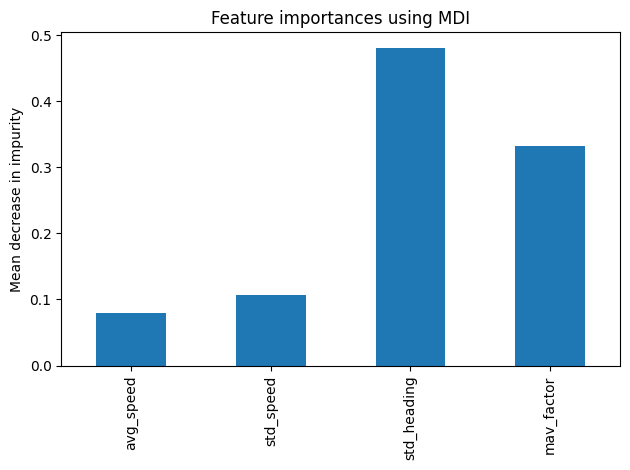

In [31]:
importance = rf.feature_importances_

forest_importance = pd.Series(importance, index=list(X_new.columns))

fig, ax = plt.subplots()
forest_importance.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Test Model on Drone Data

In [23]:
X_grouped = drone_df_new.groupby("UUID")

avg_speed = calculate_avg_speed(X_grouped)
std_speed = calculate_std_speed(X_grouped)
std_heading = X_grouped.apply(calculate_std_heading)
mav_factor = avg_speed / std_heading

X_new = pd.DataFrame({
    'avg_speed': avg_speed,
    'std_speed': std_speed,
    'std_heading': std_heading,
    'mav_factor': mav_factor
})

X_new.replace([np.nan], 0, inplace=True)
X_new.replace([np.inf], 99999, inplace=True)
X_new.replace([-np.inf], -99999, inplace=True)

y_new = X_grouped["Label"].first()

In [24]:
# use the trained model to generate predictions
rf_pred = rf.predict(X_new)

# get the confidence levels of each model
rf_confidence_pair = rf.predict_proba(X_new)

In [25]:
accuracy = metrics.accuracy_score(y_new, rf_pred)
print(f'accuracy = {100 * accuracy}')

accuracy = metrics.f1_score(y_new, rf_pred)
print(f'f1 score = {100 * accuracy}')

rf_confidence = [max(pair) for pair in rf_confidence_pair]
avg_rf_confidence = np.mean(rf_confidence)
med_rf_confidence = np.median(rf_confidence)

print(f'\naverage confidence level: {avg_rf_confidence}')
print(f'median confidence level: {med_rf_confidence}')

accuracy = 7.3426573426573425
f1 score = 13.680781758957655

average confidence level: 0.950839160839161
median confidence level: 1.0


### Save Model

In [28]:
# filename = '../models/feb25_fv.sav'
# pickle.dump(rf, open(filename, 'wb'))